In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import *
import torch

from utils import load_and_preprocess

from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
#load data
location_id = 329 # 330, 331
path = 'data/hystreet_fussgaengerfrequenzen_seit2021_new.csv'
df = load_and_preprocess(path, location_id)

df = df.loc[df['is_special_day'] == 0]

In [3]:
#split train-test manually
df_unseen = df[[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') > datetime(2023, 5, 5) for d in df['date']]]
df_seen = df[[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') <= datetime(2023, 5, 5) for d in df['date']]]

X_train = df_seen.drop(columns=["date", 'pedestrians_count', 'is_special_day'])
y_train = df_seen['pedestrians_count']

X_test = df_unseen.drop(columns=["date", 'pedestrians_count', 'is_special_day'])
y_test = df_unseen['pedestrians_count']

#to get the stats during the day
df_day = df[[6 < pd.to_datetime(d).hour < 22 for d in df['date']]]
X_daytime = df_day.drop(columns=["date", 'pedestrians_count', 'is_special_day'])
y_daytime = df_day['pedestrians_count']

In [4]:
#model parameters and fitting
model = XGBRegressor()

params = dict()
params["device"] = "cpu"
params['eta'] = 0.2
params['verbosity'] = 2
params['objective'] = 'reg:squarederror'    
params['max_depth'] = 10
model.set_params(**params)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [5]:
print("R2 Score in the training set:" , model.score(X_train, y_train))
print("R2 Score in the test set:" , model.score(X_test, y_test)) #dummy

R2 Score in the training set: 0.9986505879857359
R2 Score in the test set: 0.9423040672699661


In [6]:
print(mean_squared_error(y_test, model.predict(X_test), squared=False))
print(mean_absolute_error(y_test, model.predict(X_test)))

356.26355834959327
208.67278387408126


In [7]:
print(mean_squared_error(y_train, model.predict(X_train), squared=False))
print(mean_absolute_error(y_train, model.predict(X_train)))

52.848106129612205
33.627531831661464


In [8]:
print(np.mean(df_day['pedestrians_count']))
print(mean_squared_error(y_daytime, model.predict(X_daytime), squared=False))
print(mean_absolute_error(y_daytime, model.predict(X_daytime)))
mean_absolute_error(y_daytime, model.predict(X_daytime))/np.mean(df_day['pedestrians_count'])

2198.389697648376
270.33574000842566
134.93146958117967


0.06137741171436359

In [9]:
reals = np.array(df_unseen['pedestrians_count'])
preds = np.array(model.predict(df_unseen.drop(columns=['pedestrians_count', 'date', 'is_special_day'])))
dates = np.array([datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in df_unseen['date']])

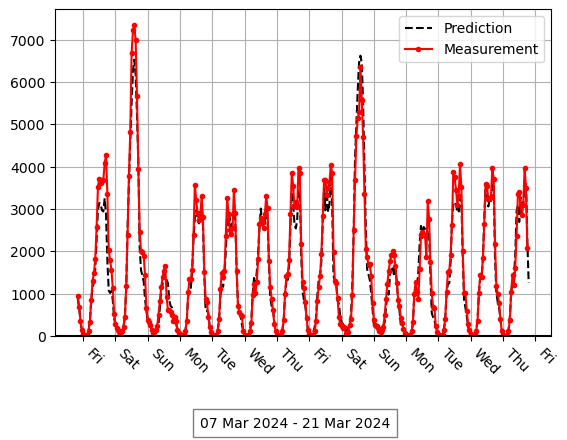

In [16]:
import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib.transforms as transforms

x = dates   [-(19*24):-(5*24)]
y = reals   [-(19*24):-(5*24)]
y2 = preds  [-(19*24):-(5*24)]

fig, ax = plt.subplots()

back = ax.plot(x, y2, '--', color='k', label = 'Prediction')
line, = ax.plot(x, y, '.-', color='r', label = 'Measurement')

ax.grid(True)

ax.axis(ymin=0)
ax.axhline(y=0, color='k')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

# Calculate and display the date range below the plot
date_range_start = x[0].strftime("%d %b %Y")
date_range_end = x[-1].strftime("%d %b %Y")
date_range_text = f"{date_range_start} - {date_range_end}"
plt.figtext(0.5, 0.01, date_range_text, ha="center", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

for label in ax.get_xticklabels():
    label.set_horizontalalignment('left')

plt.xticks(rotation=-45)
plt.legend(['Prediction','Measurement'])
def update(num, x, y, line):
    line.set_data(x[:num], y[:num])  
    return line,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=2, blit=True)

dpi = 200
writer = animation.writers['ffmpeg'](fps=30)
ani.save('test.mp4',writer=writer,dpi=dpi)

plt.show()

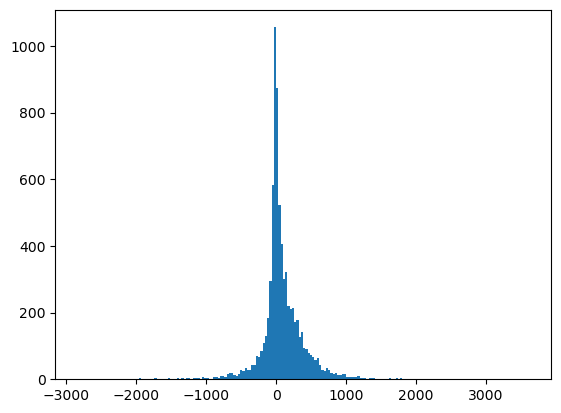

In [11]:
errors = (reals-preds)
plt.hist(errors, bins=200)
plt.show()

In [12]:
np.percentile(errors, 95)

616.1653930664062

In [13]:
np.percentile(errors, 5)

-342.12644653320314

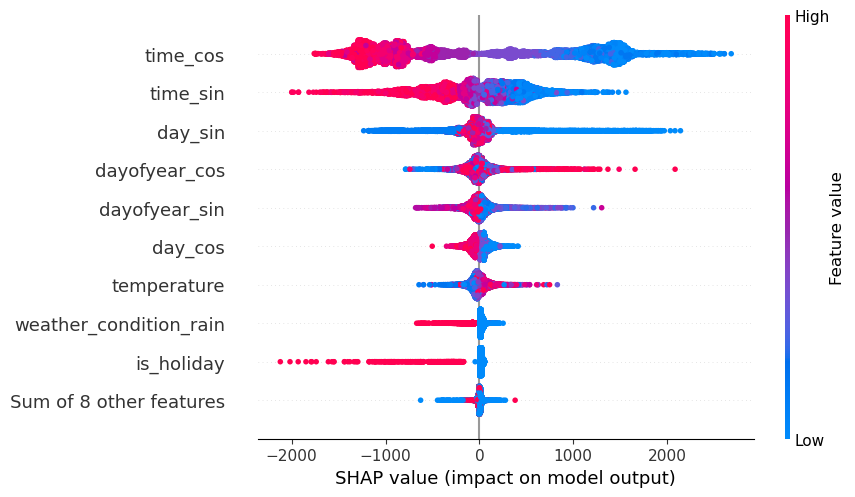

In [14]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.beeswarm(shap_values, max_display=10)